## Set up virtual environment 

In [1]:
import os
path='/work/student_folders/Ida_D_folder/notebooks_fMRI' # Remember to change this to your own path
os.chdir(path)
!/work/notebooks_fMRI/activate.sh

Installed kernelspec virt_env in /home/ucloud/.local/share/jupyter/kernels/virt_env
Done! Remember changing the kernel in Jupyter.


## Imports 

In [1]:
# Additional imports
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pickle
import pandas as pd

Matplotlib is building the font cache; this may take a moment.


## Load in data

In [2]:
# Import models from univariate analysis 

import pickle

now = datetime.now()
print('Starting cell:',now.strftime("%H:%M:%S"))

f = open('/work/student_folders/Ida_D_folder/notebooks_fMRI/Portfolio_2/results_win_decks/iowa2024_first_level_models_all.pkl', 'rb')
models, models_run_imgs, models_events, models_confounds = pickle.load(f)
f.close()



now = datetime.now()
print('Loaded models:',now.strftime("%H:%M:%S"))

Starting cell: 16:16:50
Loaded models: 16:16:53


In [3]:
# Inspect number of scans and confounds included in the first participant, first run:
print(models_confounds[0][0].shape)
# Inspect number of trials, onsets and trial types for the first participant, first run:
print(models_events[0][0])

print('Current participant: ', models[0].subject_label)

(600, 22)
         onset  duration trial_type
0     0.987616       5.0      decks
1    15.976075       5.0      decks
2    30.976804       5.0      decks
3    45.977655       5.0      decks
4    60.978251       5.0      decks
..         ...       ...        ...
75  536.532664       2.0        win
76  551.533407       2.0    neutral
77  566.534108       2.0        win
78  581.534830       2.0        win
79  596.535519       2.0        win

[80 rows x 3 columns]
Current participant:  0136


## Creating new design matrices with a column per experimental trial.

In [4]:
# The idea is that each trial becomes a new predictor in the new design matrix

import pandas as pd
from nilearn.glm.first_level import make_first_level_design_matrix
import numpy as np
lsa_dm=[]

# Changing the model for a single participant (the first):
for ii in range(len(models_events[0])):
    # Sort onsets by trial type to make later processing easier
    #models_events[0][ii].sort_values(by=['trial_type'], inplace=True)
    #N=number of events
    N=models_events[0][ii].shape[0]
    # time frame with 600 scans with 1s TR:
    t_fmri = np.linspace(0, 600,600,endpoint=False)
    # We have to create a dataframe with onsets/durations/trial_types
    # No need for modulation!
    trials = pd.DataFrame(models_events[0][ii], columns=['onset'])
    trials.loc[:, 'duration'] = 2 # decks are actually 5 s, but we will simplify
    trials.loc[:, 'trial_type'] = [models_events[0][ii]['trial_type'][i-1]+'_'+'t_'+str(i).zfill(3)  for i in range(1, N+1)]

    # lsa_dm = least squares all design matrix
    lsa_dm.append(make_first_level_design_matrix(
        frame_times=t_fmri,  # we defined this earlier 
        events=trials,
        add_regs=models_confounds[0][ii], #Add the confounds from fmriprep
        hrf_model='glover',
        drift_model='cosine'  
    ))

now = datetime.now()
print('Finish making single trial models:',now.strftime("%H:%M:%S"))

Finish making single trial models: 16:17:17


### Plot the new design matrix

Finishing cell: 16:17:23


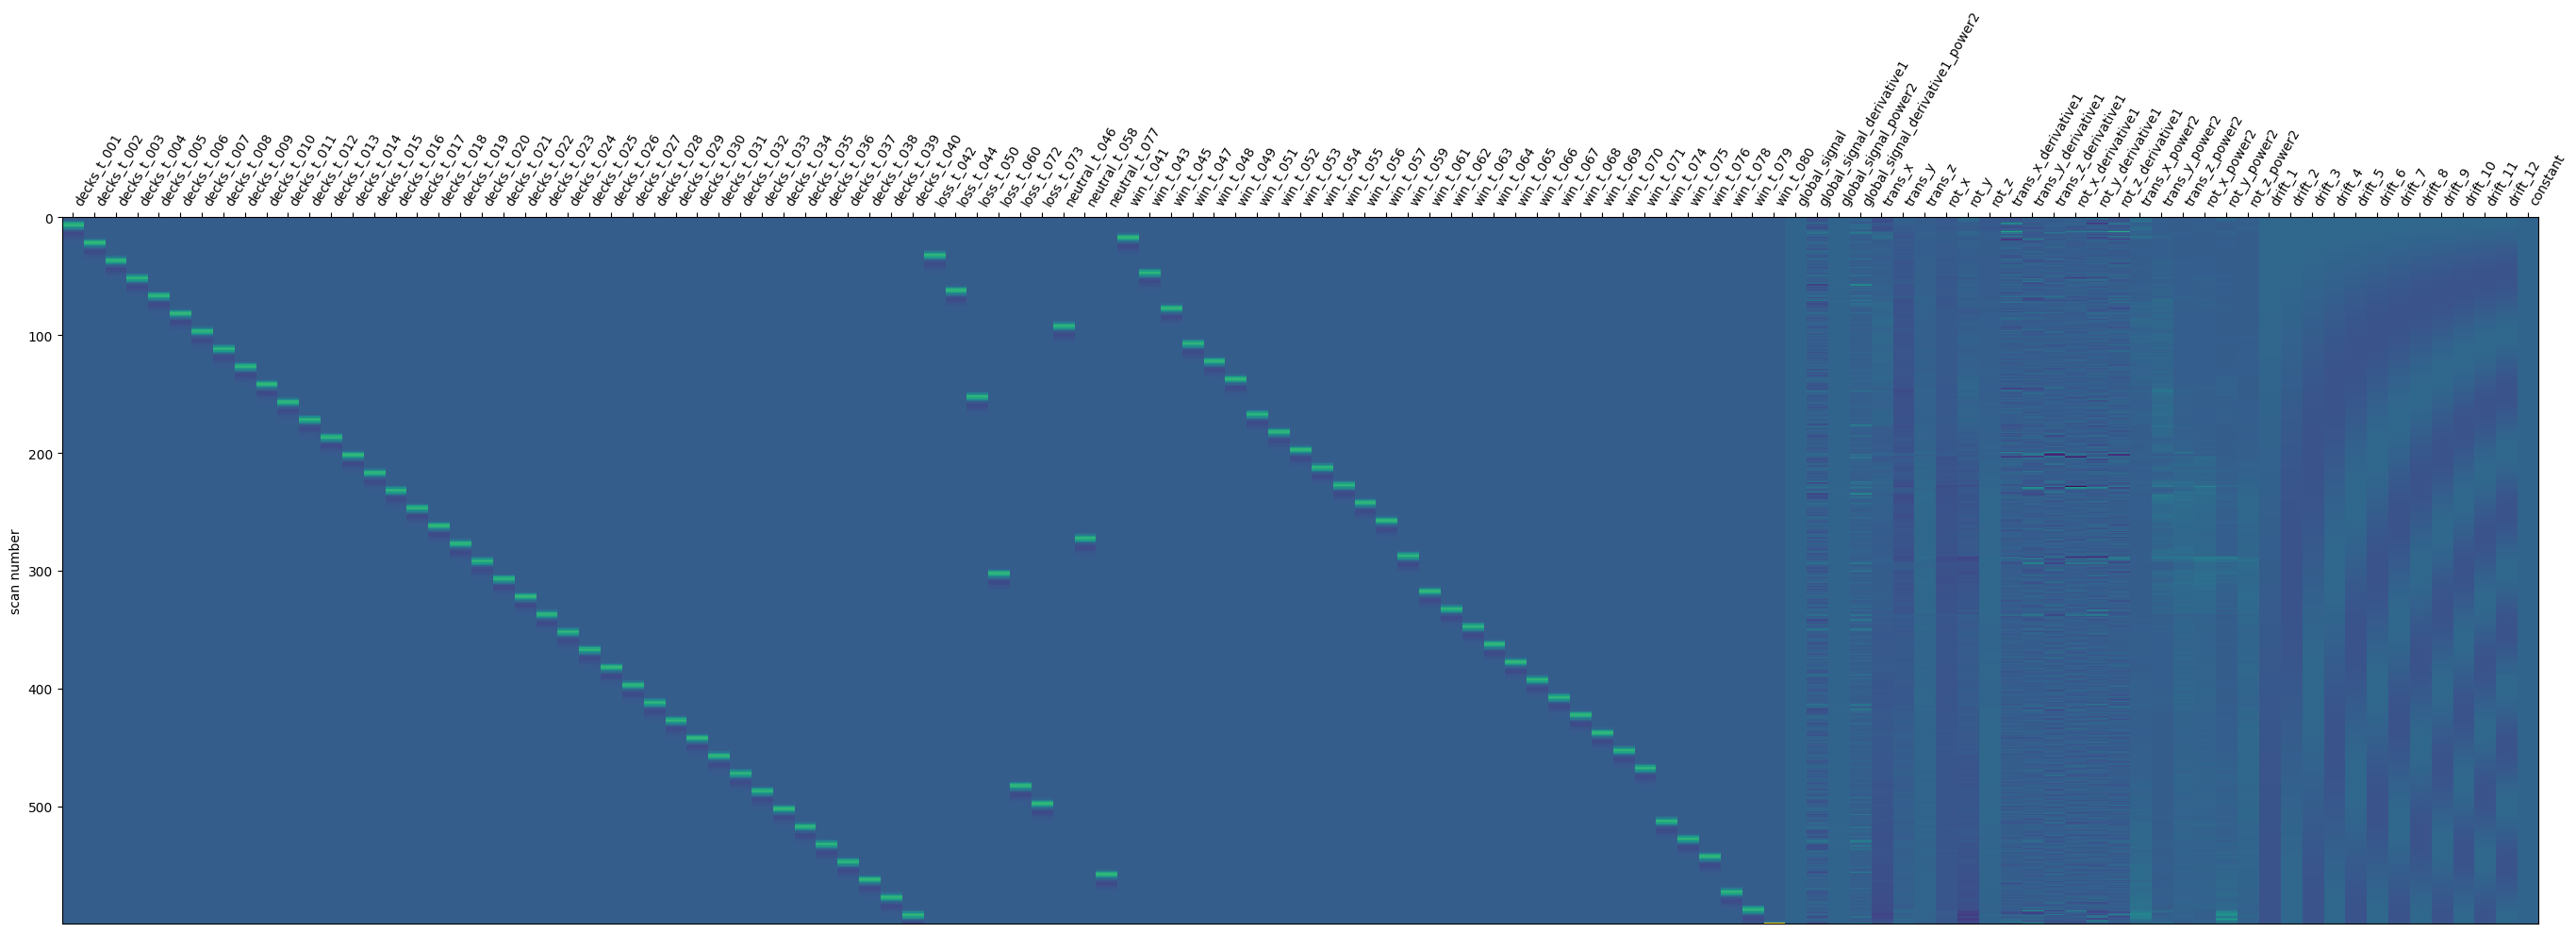

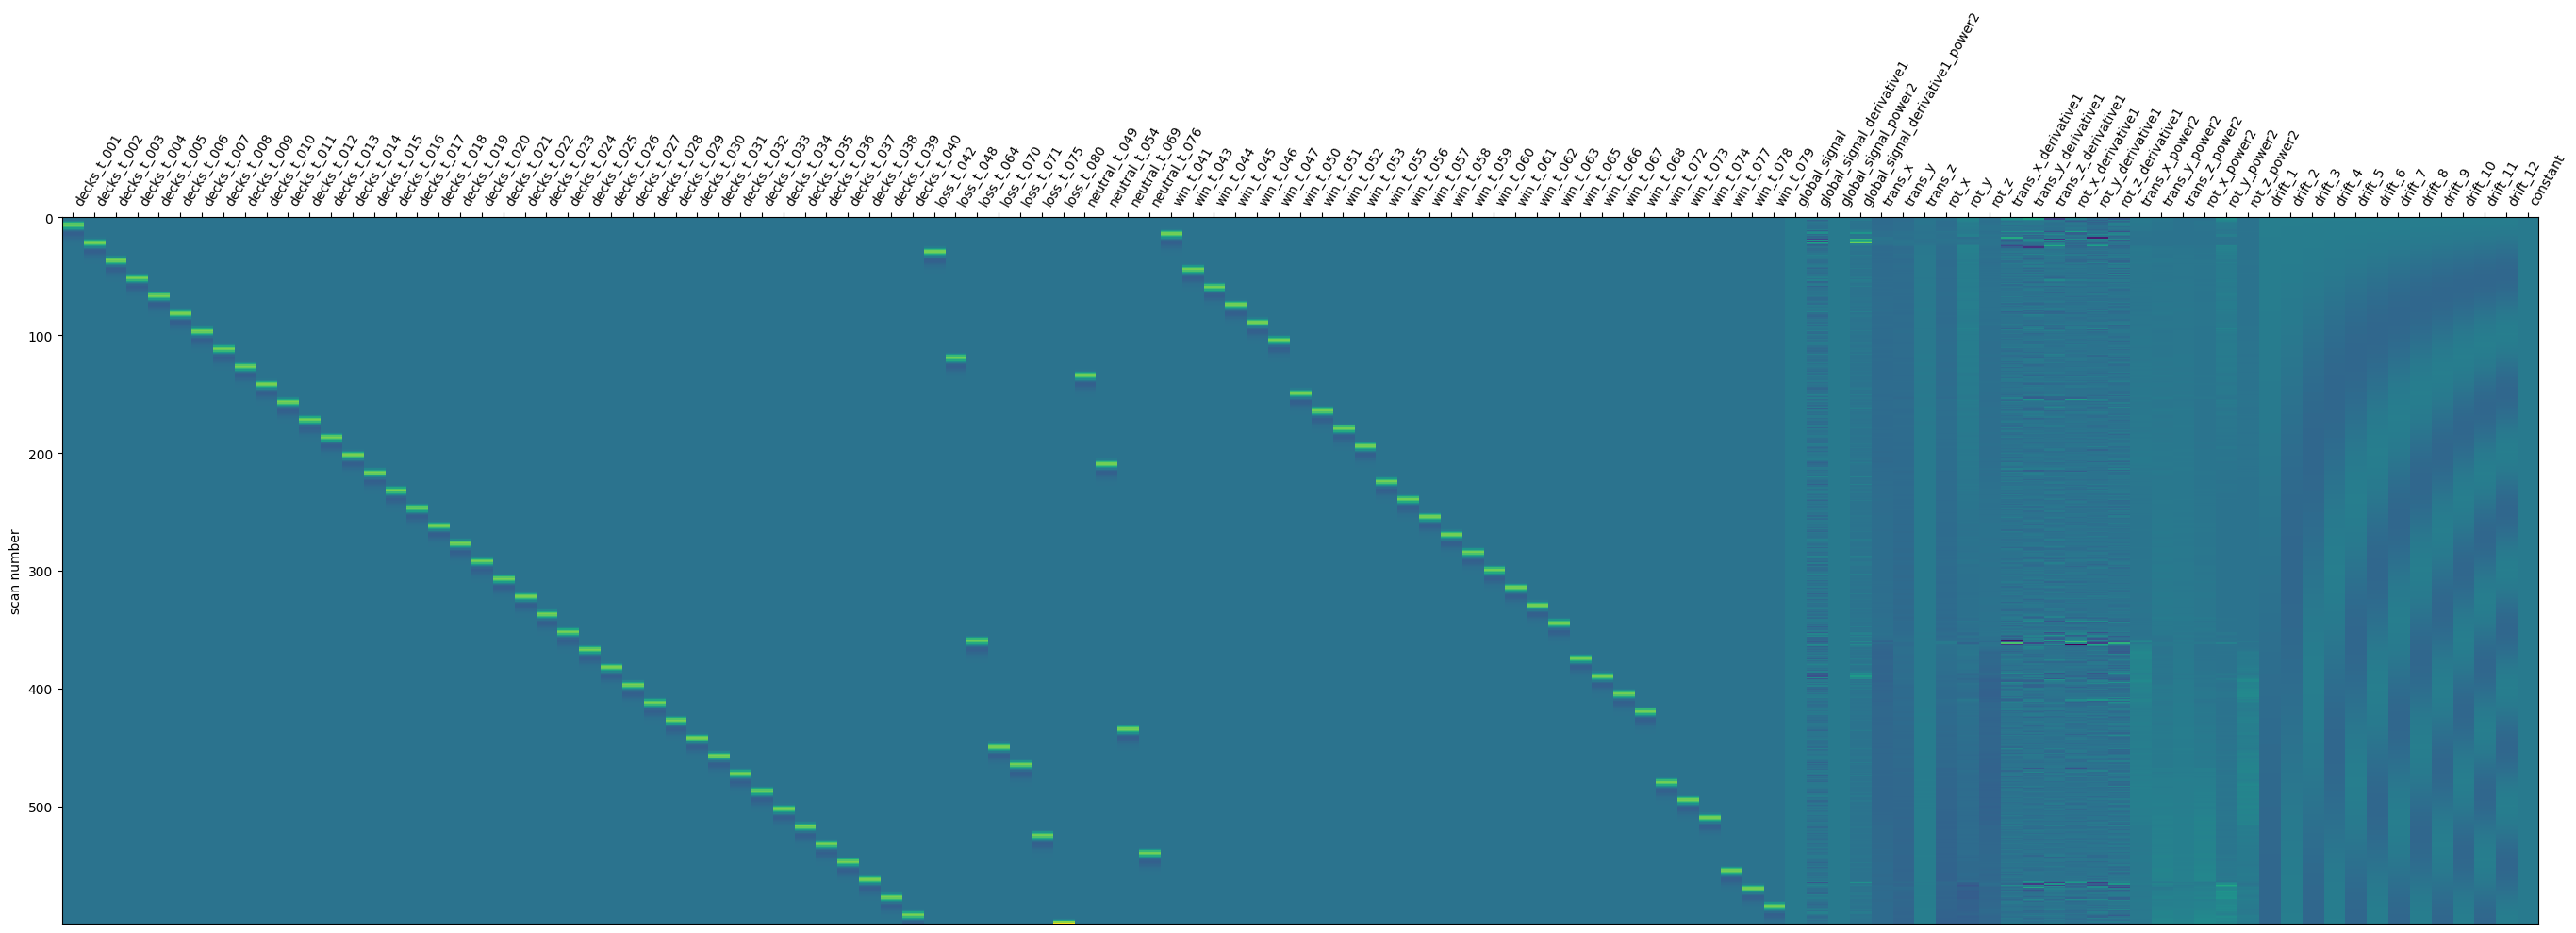

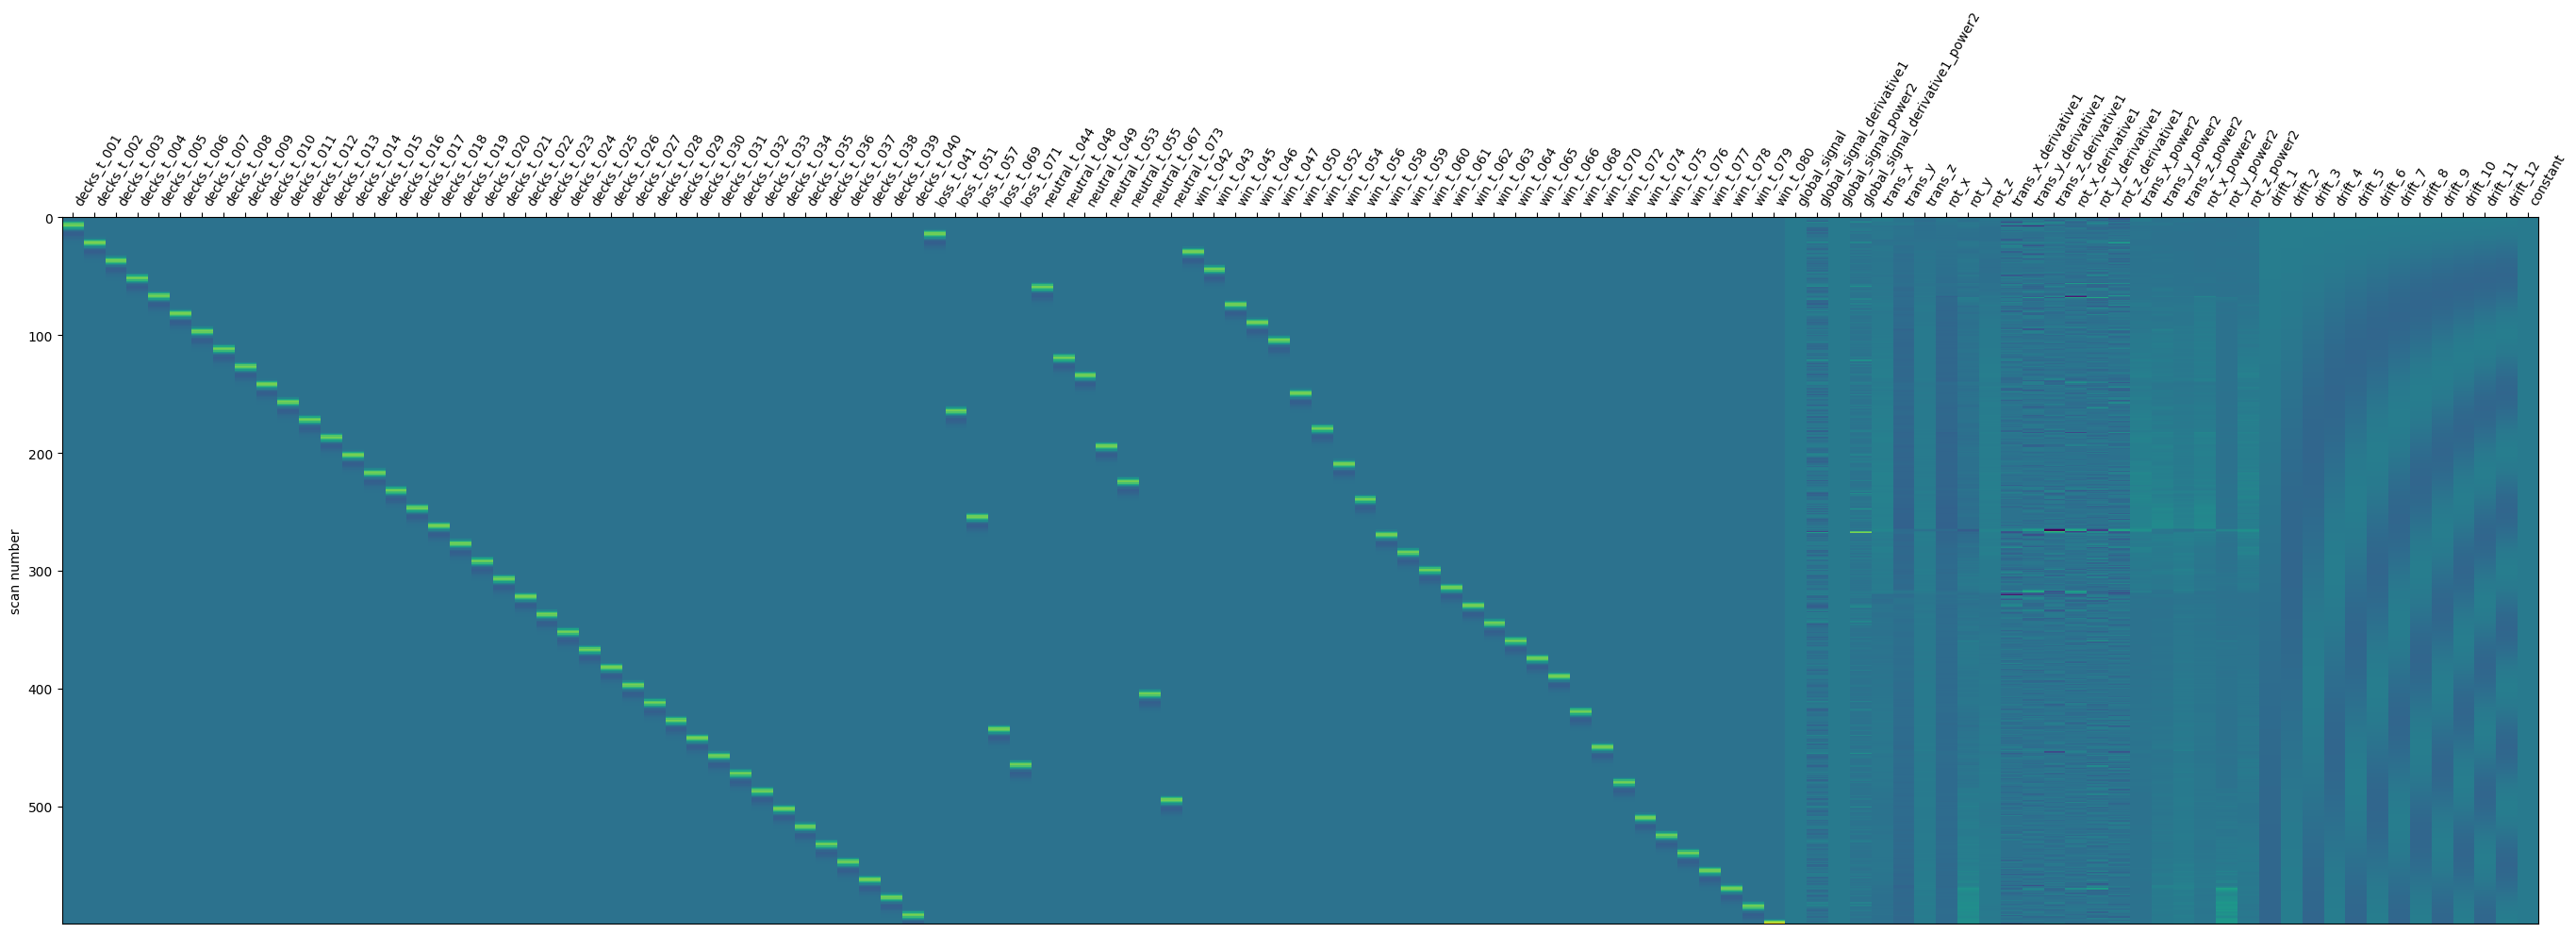

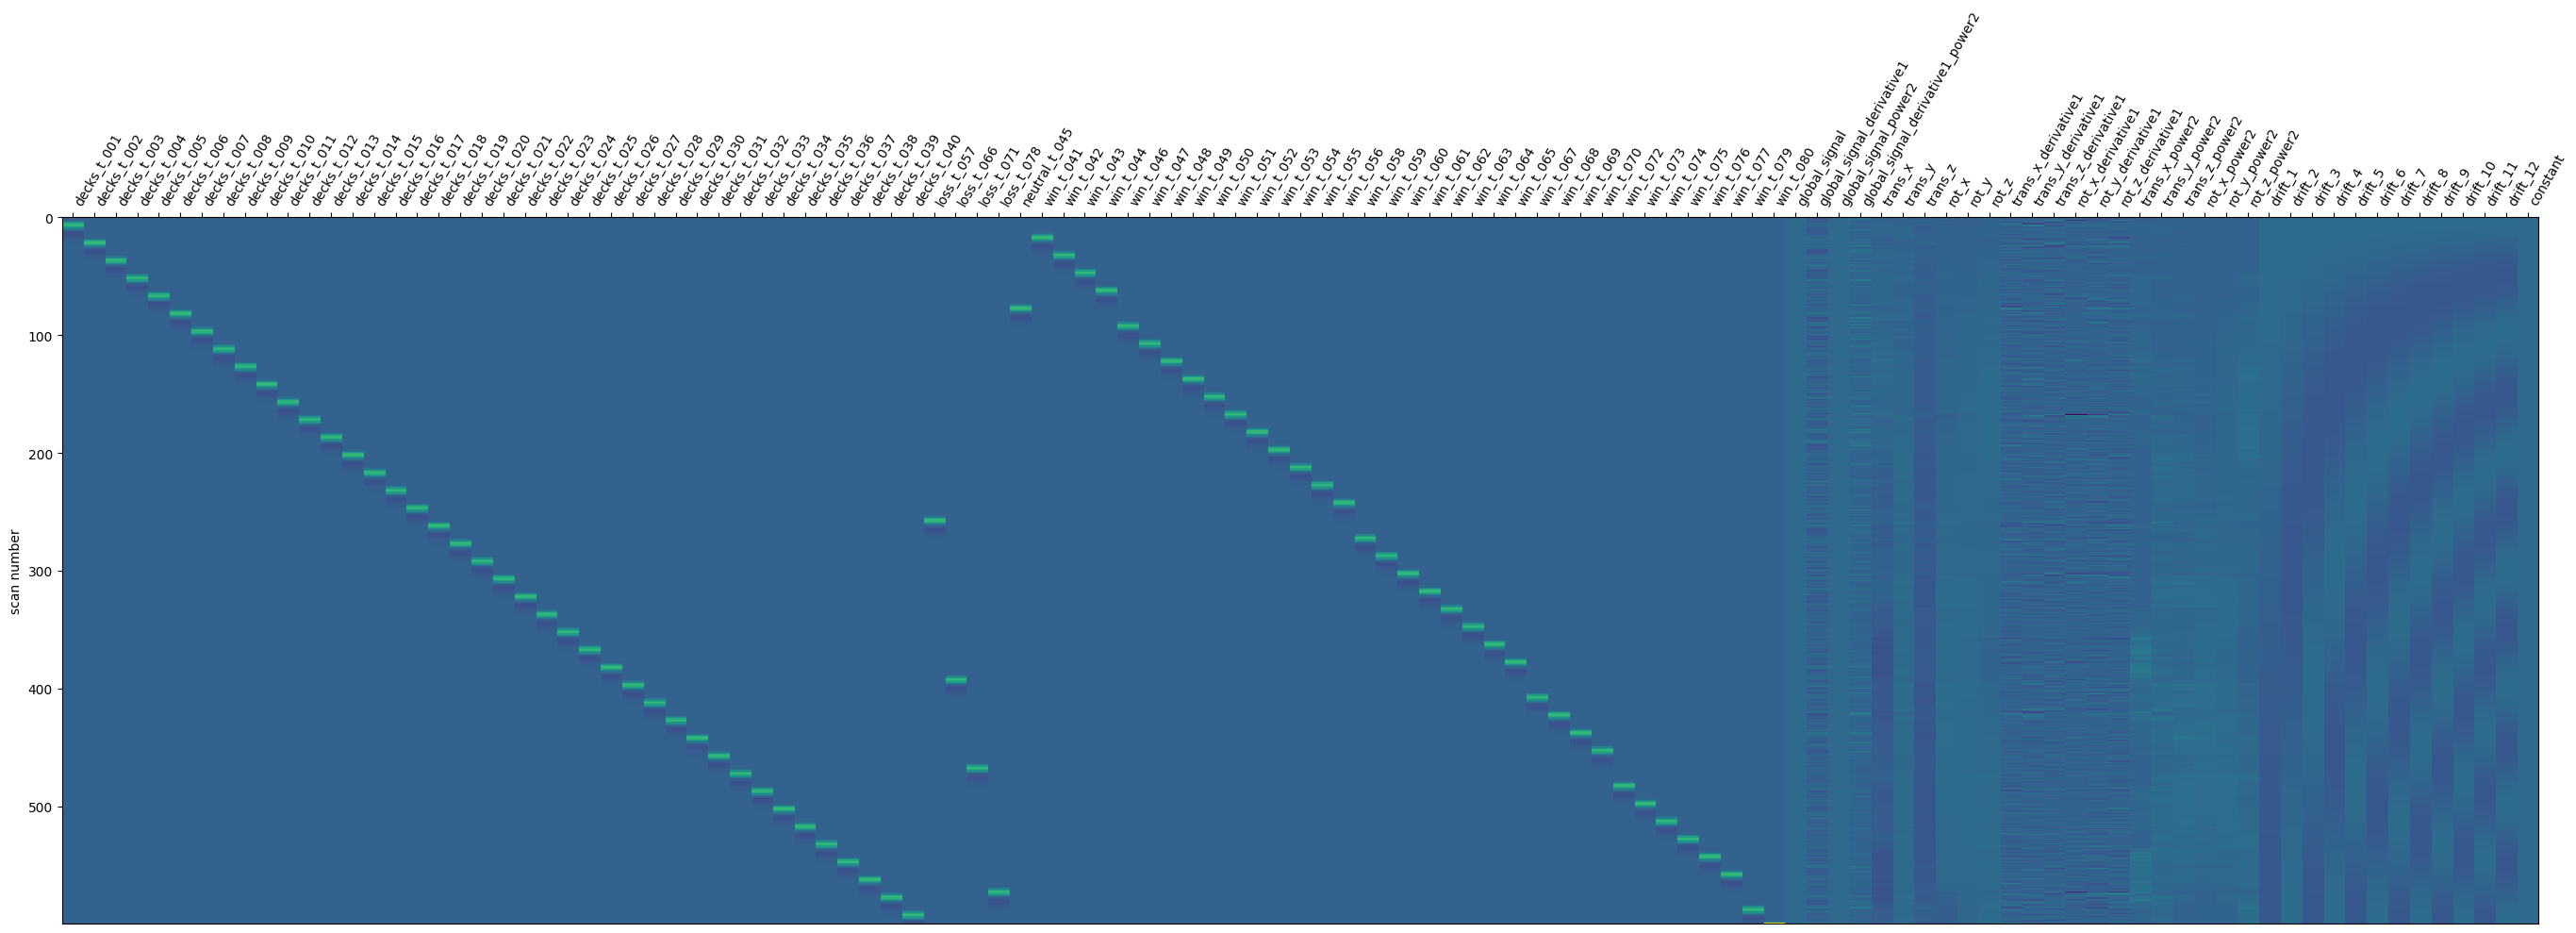

In [5]:
# Plot the new design matrix, 1 for each run 

from nilearn.plotting import plot_design_matrix
for ii in range(len(models_events[0])):
    plot_design_matrix(lsa_dm[ii]);

now = datetime.now()
print('Finishing cell:',now.strftime("%H:%M:%S"))

# we see that win/loss/neutral are correlated. Lets investigate that further:

### Inspect the correlational structure of the design matrix

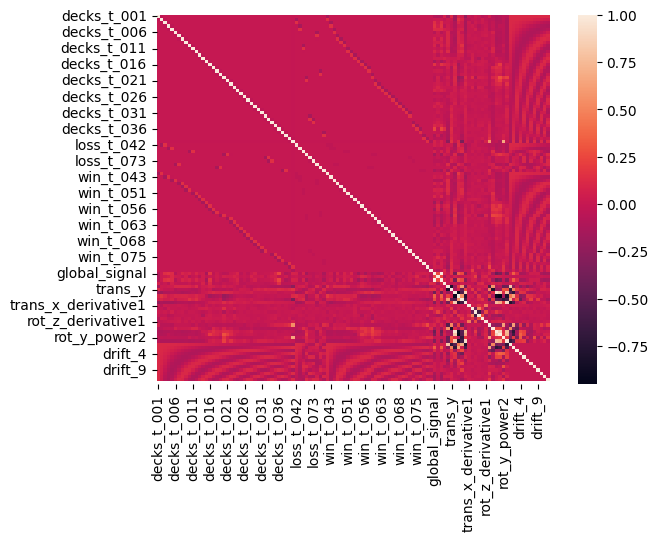

In [6]:
import seaborn as sns
dm_corr=lsa_dm[0].corr()
p1 = sns.heatmap(dm_corr)

## Fit the models for all sessions from one participant

In [7]:
# Fit 1 GLM per session 

from nilearn.glm.first_level import FirstLevelModel

model1=[]
for ii in range(len(models_events[0])):
    
    # Get data and model info for 1st participant, 1st session
    imgs1=models_run_imgs[0][ii]
    model1.append (FirstLevelModel())
    #Fit the model
    print('Fitting GLM: ', ii+1)
    model1[ii].fit(imgs1,design_matrices=lsa_dm[ii])

now = datetime.now()
print('Finishing model fit:',now.strftime("%H:%M:%S"))

Fitting GLM:  1
Fitting GLM:  2
Fitting GLM:  3
Fitting GLM:  4
Finishing model fit: 16:23:32


## Saving/retrieving the fitted models and design matrices

In [8]:
import pickle

# Saving the objects:
f = open('/work/student_folders/Ida_D_folder/notebooks_fMRI/Portfolio_2/Decoding/iowa_first_level_models_all_trials.pkl', 'wb')
pickle.dump([model1, lsa_dm], f)
f.close()

## Getting back the objects:
#f = open('/work/MikkelWallentin#6287/InSpe_first_level_models_all_trials.pkl', 'rb')
#model1, lsa_dm = pickle.load(f)
#f.close()

#print(model1[0])
now = datetime.now()
print('Saved model and design matrices:',now.strftime("%H:%M:%S"))

Saved model and design matrices: 16:26:29


## Making beta map contrasts from the fitted model to use in later analyses

In [10]:
now = datetime.now()
print('Computing contrasts:',now.strftime("%H:%M:%S"))
b_maps = []
conditions_label = []

for ii in range(len(models_events[0])):
    N=models_events[0][ii].shape[0]
    #Make an identity matrix with N= number of trials
    contrasts=np.eye(N)
    #print(contrasts.shape)
    #Find difference between columns in design matrix and number of trials
    dif=lsa_dm[ii].shape[1]-contrasts.shape[1]
    #print(dif)
    #Pad with zeros
    contrasts=np.pad(contrasts, ((0,0),(0,dif)),'constant')
    #print(contrasts.shape)
    print('Making contrasts for session : ', ii+1)
    print('Number of contrasts : ', N)
    for i in range(N):
        #Add a beta-contrast image from each trial
        b_maps.append(model1[ii].compute_contrast(contrasts[i,], output_type='effect_size'))
        # Make a variable with condition labels for use in later classification
        conditions_label.append(lsa_dm[ii].columns[i])
#        session_label.append(session)

now = datetime.now()
print('Done computing contrasts:',now.strftime("%H:%M:%S"))


Computing contrasts: 16:26:46
Making contrasts for session :  1
Number of contrasts :  80
Making contrasts for session :  2
Number of contrasts :  80
Making contrasts for session :  3
Number of contrasts :  80
Making contrasts for session :  4
Number of contrasts :  80
Done computing contrasts: 16:28:19


## Saving models and beta maps

In [11]:
import pickle

#Save the first level models

# Saving the objects:
f = open('/work/student_folders/Ida_D_folder/notebooks_fMRI/Portfolio_2/Decoding/iowa2024_first_level_models_all_trials.pkl', 'wb')
pickle.dump([model1, lsa_dm, conditions_label, b_maps], f)
f.close()

# Getting back the objects:
#f = open('/work/MikkelWallentin#6287/InSpe_first_level_models_all_trials.pkl', 'rb')
#model1, lsa_dm, conditions_label, b_maps = pickle.load(f)
#f.close()

now = datetime.now()
print('Saved beta-maps:',now.strftime("%H:%M:%S"))

del model1

Saved beta-maps: 16:28:26


## Reshape data for classification
Checking that the design matrix and the condition labels look the same.

In [12]:
print('Checking that column names for design matrix matches labels')
print(lsa_dm[0].columns[0:9])
print(conditions_label[0:9])

Checking that column names for design matrix matches labels
Index(['decks_t_001', 'decks_t_002', 'decks_t_003', 'decks_t_004',
       'decks_t_005', 'decks_t_006', 'decks_t_007', 'decks_t_008',
       'decks_t_009'],
      dtype='object')
['decks_t_001', 'decks_t_002', 'decks_t_003', 'decks_t_004', 'decks_t_005', 'decks_t_006', 'decks_t_007', 'decks_t_008', 'decks_t_009']


In [13]:

now = datetime.now()
print('Renaming labels to decks, outcome:',now.strftime("%H:%M:%S"))

f = open('/work/student_folders/Ida_D_folder/notebooks_fMRI/Portfolio_2/Decoding/iowa2024_first_level_models_all_trials.pkl', 'rb')
model1, lsa_dm, conditions_label, b_maps = pickle.load(f)
f.close()

import numpy as np
#from nilearn import datasets
from nilearn.image import new_img_like, load_img, index_img, clean_img, concat_imgs
from sklearn.model_selection import train_test_split, GroupKFold
n_trials=len(conditions_label)
#print(n_trials)

#Concatenate beta maps
b_maps_conc=concat_imgs(b_maps)
#print(b_maps_conc.shape)
del b_maps
# Reshaping data------------------------------
from nilearn.image import index_img, concat_imgs



#Find all negative and positive trials
idx_decks=[int(i) for i in range(n_trials) if 'decks_' in conditions_label[i]]
idx_win=[int(i) for i in range(n_trials) if 'win_' in conditions_label[i]]
idx_loss=[int(i) for i in range(n_trials) if 'loss_' in conditions_label[i]]
idx_neutral=[int(i) for i in range(n_trials) if 'neutral_' in conditions_label[i]]


##Make an index for decks/outcome sessions #


for i in range(len(conditions_label)):
    if i in idx_decks:
        conditions_label[i]='decks'
    if i in idx_win:
        conditions_label[i]='outcome'
    if i in idx_loss:
        conditions_label[i]='outcome'
    if i in idx_neutral:
        conditions_label[i]='outcome'

print(conditions_label)

now = datetime.now()
print('Selecting N and B:',now.strftime("%H:%M:%S"))
# Make index of relevant trials
idx=np.concatenate((idx_decks, idx_win,idx_loss,idx_neutral))

#Select trials
conditions=np.array(conditions_label)[idx]
print(conditions)

#Select images
b_maps_img = index_img(b_maps_conc, idx)
print(b_maps_img.shape)


Renaming labels to decks, outcome: 16:28:56
['decks', 'decks', 'decks', 'decks', 'decks', 'decks', 'decks', 'decks', 'decks', 'decks', 'decks', 'decks', 'decks', 'decks', 'decks', 'decks', 'decks', 'decks', 'decks', 'decks', 'decks', 'decks', 'decks', 'decks', 'decks', 'decks', 'decks', 'decks', 'decks', 'decks', 'decks', 'decks', 'decks', 'decks', 'decks', 'decks', 'decks', 'decks', 'decks', 'decks', 'outcome', 'outcome', 'outcome', 'outcome', 'outcome', 'outcome', 'outcome', 'outcome', 'outcome', 'outcome', 'outcome', 'outcome', 'outcome', 'outcome', 'outcome', 'outcome', 'outcome', 'outcome', 'outcome', 'outcome', 'outcome', 'outcome', 'outcome', 'outcome', 'outcome', 'outcome', 'outcome', 'outcome', 'outcome', 'outcome', 'outcome', 'outcome', 'outcome', 'outcome', 'outcome', 'outcome', 'outcome', 'outcome', 'outcome', 'outcome', 'decks', 'decks', 'decks', 'decks', 'decks', 'decks', 'decks', 'decks', 'decks', 'decks', 'decks', 'decks', 'decks', 'decks', 'decks', 'decks', 'decks', 'd

## create training and testing vars on the basis of class labels

In [14]:
now = datetime.now()
print('Making a trial and test set:',now.strftime("%H:%M:%S"))
#conditions_img=conditions[idx]
#print(conditions_img)
#Make an index for spliting fMRI data with same size as class labels
idx2=np.arange(conditions.shape[0])

# create training and testing vars on the basis of class labels
idx_train,idx_test, conditions_train,  conditions_test = train_test_split(idx2,conditions, test_size=0.2)
#print(idx_train, idx_test)

# Reshaping data------------------------------
from nilearn.image import index_img
fmri_img_train = index_img(b_maps_img, idx_train)
fmri_img_test = index_img(b_maps_img, idx_test)
#Check data sizes
print('Trial and test set shape:')
print(fmri_img_train.shape)
print(fmri_img_test.shape)

# Saving the objects:
f = open('/work/student_folders/Ida_D_folder/notebooks_fMRI/Portfolio_2/Decoding/iowa2024_first_level_models_testtrain.pkl', 'wb')
pickle.dump([fmri_img_train, fmri_img_test, idx_train,idx_test, conditions_train,  conditions_test], f)
f.close()

now = datetime.now()
print('Trial and test set saved:',now.strftime("%H:%M:%S"))

Making a trial and test set: 16:29:04
Trial and test set shape:
(78, 92, 78, 256)
(78, 92, 78, 64)
Trial and test set saved: 16:29:05


## Prepare a searchlight analysis on the first split

Making a mask for analysis: 16:29:19


/tmp/ipykernel_525/317195316.py:29: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  process_mask_img = new_img_like(mask_img, process_mask)


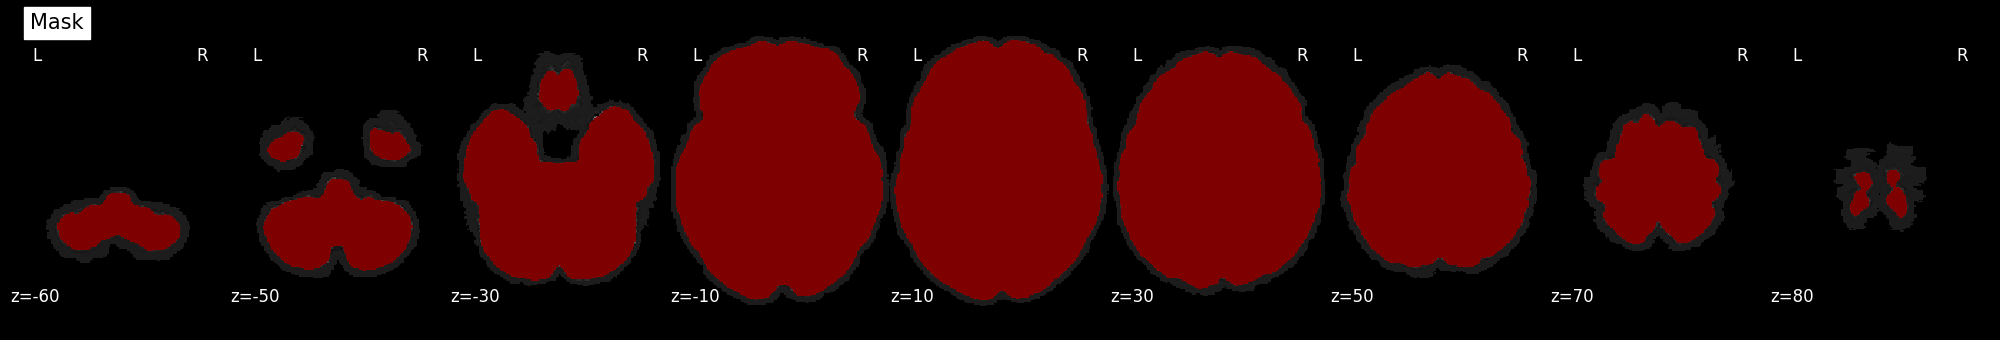

In [15]:
now = datetime.now()
print('Making a mask for analysis:',now.strftime("%H:%M:%S"))
# -------------------
import pandas as pd
import numpy as np
from nilearn.image import new_img_like, load_img
from nilearn.plotting import plot_stat_map, plot_img, show
from nilearn import decoding
from nilearn.decoding import SearchLight
from sklearn import naive_bayes, model_selection #import GaussianNB

#########################################################################
#Make a mask with the whole brain

subj=models[0].subject_label
mask_wb_filename='/work/fMRI_data/BIDS_2024E/derivatives/sub-'+subj+'/ses-001/anat/sub-'+subj+'_ses-001_acq-T1sequence_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'
anat_filename='/work/fMRI_data/BIDS_2024E/derivatives/sub-'+subj+'/ses-001/anat/sub-'+subj+'_ses-001_acq-T1sequence_run-1_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz'

#Load the whole brain mask
mask_img = load_img(mask_wb_filename)

## This bit can be used if you want to make a smaller select of the brain to study (e.g. to speed up analsysis)
# .astype() makes a copy.
process_mask = mask_img.get_fdata().astype(int)
#Set slices below x in the z-dimension to zero (in voxel space)
process_mask[..., :10] = 0
#Set slices above x in the z-dimension to zero (in voxel space)
process_mask[..., 170:] = 0
process_mask_img = new_img_like(mask_img, process_mask)


#Plot the mask on an anatomical background
plot_img(process_mask_img, bg_img=anat_filename,#bg_img=mean_fmri,
         title="Mask", display_mode="z",cut_coords=[-60,-50,-30,-10,10,30,50,70,80],
         vmin=.40, cmap='jet', threshold=0.9, black_bg=True)


## Run the searchlight analysis

Note. This takes many hours for one participant

In [17]:
now = datetime.now()
print('Starting searchlight analysis:',now.strftime("%H:%M:%S"))
#n_jobs=-1 means that all CPUs will be used

from nilearn.decoding import SearchLight
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB

# The radius is the one of the Searchlight sphere that will scan the volume
searchlight = SearchLight(
    mask_img,
    estimator=GaussianNB(),
    process_mask_img=process_mask_img,
    radius=5, n_jobs=-1,
    verbose=10, cv=10)
searchlight.fit(fmri_img_train, conditions_train)

now = datetime.now()
print('Finishing searchlight analysis:',now.strftime("%H:%M:%S"))

Starting searchlight analysis: 16:49:50


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 60 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 18.3min
[Parallel(n_jobs=-1)]: Done   4 out of  60 | elapsed: 18.5min remaining: 259.2min
[Parallel(n_jobs=-1)]: Done  11 out of  60 | elapsed: 18.8min remaining: 83.7min
[Parallel(n_jobs=-1)]: Done  18 out of  60 | elapsed: 18.9min remaining: 44.2min
[Parallel(n_jobs=-1)]: Done  25 out of  60 | elapsed: 19.0min remaining: 26.5min
[Parallel(n_jobs=-1)]: Done  32 out of  60 | elapsed: 19.0min remaining: 16.6min
[Parallel(n_jobs=-1)]: Done  39 out of  60 | elapsed: 19.0min remaining: 10.2min
[Parallel(n_jobs=-1)]: Done  46 out of  60 | elapsed: 19.1min remaining:  5.8min
[Parallel(n_jobs=-1)]: Done  53 out of  60 | elapsed: 19.1min remaining:  2.5min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 19.2min finished


Finishing searchlight analysis: 19:28:27


## Save/restore the variables

In [18]:
import pickle
import nilearn

import os
outdir='/work/student_folders/Ida_D_folder/notebooks_fMRI/Portfolio_2/Decoding'
if not os.path.exists(outdir):
    os.mkdir(outdir)
#Save the searchlight model

# Saving the objects:
search_file=outdir+'/iowa2024_first_level_models_all_trials_searchlight.pkl'
f = open(search_file, 'wb')
pickle.dump([searchlight, searchlight.scores_], f)
f.close()

# Getting back the objects:
#f = open('/work/MikkelWallentin#6287/InSpe_first_level_models_all_trials_searchlight.pkl', 'rb')
#searchlight,searchlight_scores_ = pickle.load(f)
#f.close()


# Getting back the objects:
#f = open('/work/MikkelWallentin#6287/InSpe_first_level_models_testtrain.pkl', 'rb')
#fmri_img_train, fmri_img_test, idx_train,idx_test, conditions_train,  conditions_test= pickle.load(f)
#f.close()

# Getting back the objects:
#f = open('/work/MikkelWallentin#6287/InSpe_one_sub_all_trials_searchlightNB.pkl', 'rb')
#searchlight,searchlight_scores_ = pickle.load(f)
#f.close()


now = datetime.now()
print('Searchlight output saved:',now.strftime("%H:%M:%S"))


Searchlight output saved: 09:07:18


## Plot the outcome of the searchlight analysis

Plotting and saving searchlight output (threshold:0.6): 09:07:30


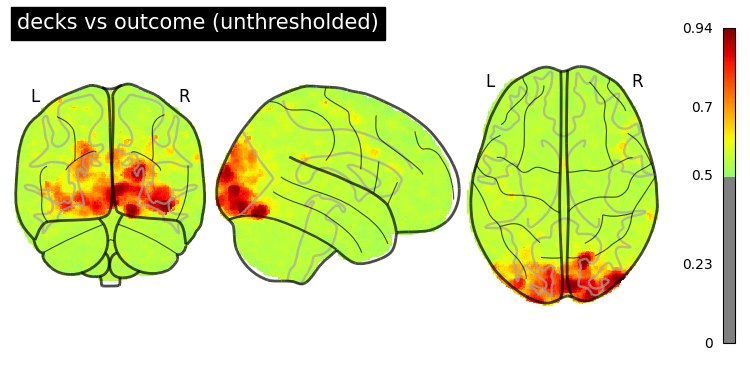

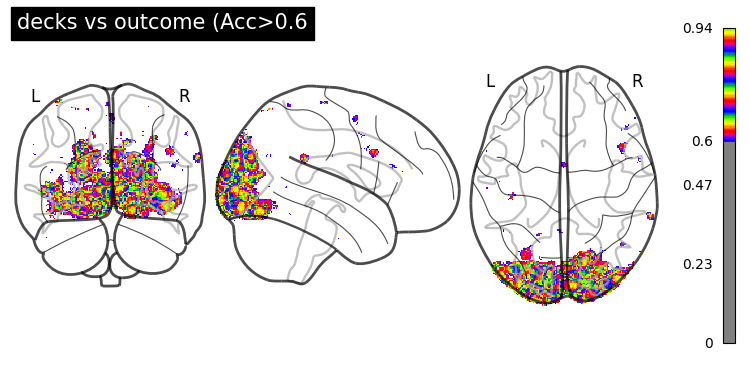

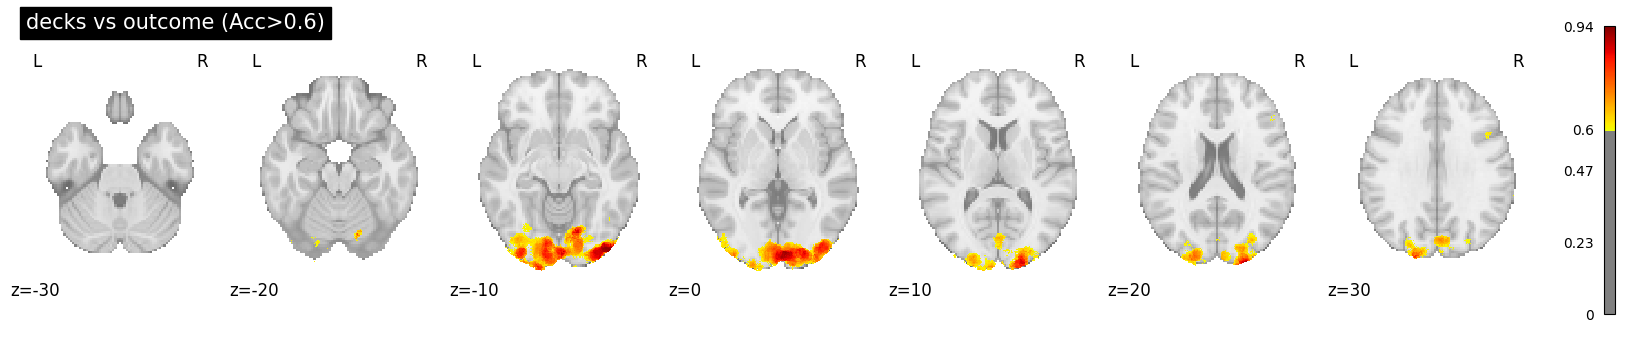

In [19]:
from nilearn import image, plotting
from nilearn.plotting import plot_glass_brain, plot_stat_map
from nilearn.image import new_img_like, load_img
subj=models[0].subject_label
mask_wb_filename='/work/fMRI_data/BIDS_2024E/derivatives/sub-'+subj+'/ses-001/anat/sub-'+subj+'_ses-001_acq-T1sequence_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'
anat_filename='/work/fMRI_data/BIDS_2024E/derivatives/sub-'+subj+'/ses-001/anat/sub-'+subj+'_ses-001_acq-T1sequence_run-1_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz'

now = datetime.now()
print('Plotting and saving searchlight output (threshold:0.6):',now.strftime("%H:%M:%S"))

#Create an image of the searchlight scores
searchlight_img = new_img_like(anat_filename, searchlight.scores_)


plot_glass_brain(searchlight_img, cmap='jet',colorbar=True, threshold=0.5,
                          title='decks vs outcome (unthresholded)',
                          plot_abs=False)

fig=plotting.plot_glass_brain(searchlight_img,cmap='prism',colorbar=True,threshold=0.60,title='decks vs outcome (Acc>0.6')
fig_file=outdir+'/iowa2024_sub-'+subj+'decks_vs_outcome_searchlightNB_glass.png'
fig.savefig(fig_file, dpi=300)
#plt.show()

plot_stat_map(searchlight_img, cmap='jet',threshold=0.6, cut_coords=[-30,-20,-10,0,10,20,30],
              display_mode='z',  black_bg=False,
              title='decks vs outcome (Acc>0.6)')
plt.show()

### Find the 500 most predictive voxels 

In [20]:
print('Number of voxels in searchlight: ',searchlight.scores_.size)
#Find the percentile that makes the cutoff for the 500 best voxels
perc=100*(1-500.0/searchlight.scores_.size)
#Print percentile
print('Percentile for 500 most predictive voxels: ',perc)
#Find the cutoff
cut=np.percentile(searchlight.scores_,perc)
#Print cutoff
print('Cutoff for 500 most predictive voxels: ', cut)
#cut=0
#Make a mask using cutoff

#Load the whole brain mask
mask_img2 = load_img(mask_wb_filename)

# .astype() makes a copy.
process_mask2 = mask_img2.get_fdata().astype(int)
process_mask2[searchlight.scores_<=cut] = 0
process_mask2_img = new_img_like(mask_img2, process_mask2)



Number of voxels in searchlight:  8980290
Percentile for 500 most predictive voxels:  99.9944322510743
Cutoff for 500 most predictive voxels:  0.8986153846153847


/tmp/ipykernel_525/642982622.py:19: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  process_mask2_img = new_img_like(mask_img2, process_mask2)


### Visualization of the voxels

/work/notebooks_fMRI/virt_env/lib/python3.10/site-packages/numpy/ma/core.py:2820: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,


Saving glass brain with 500 most predictive voxels: 09:08:36


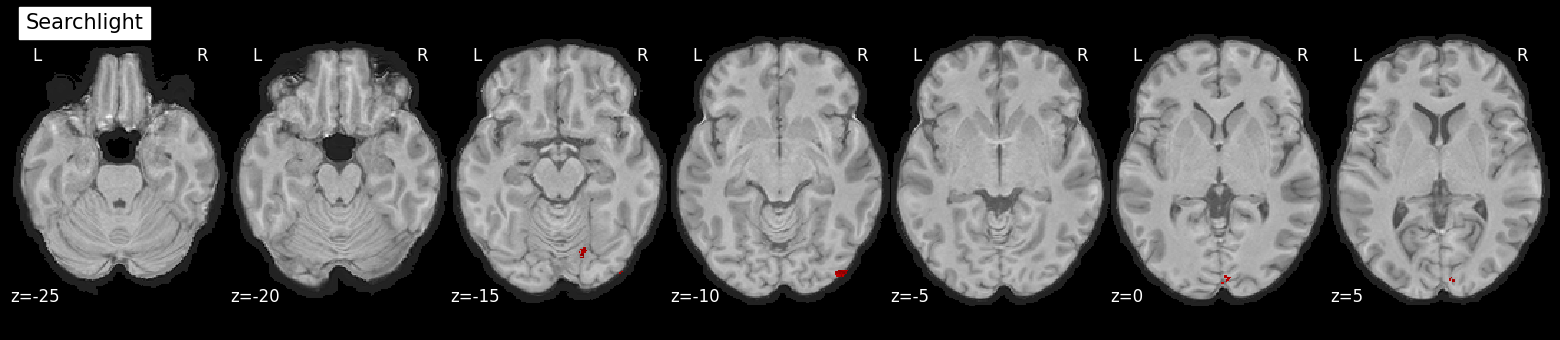

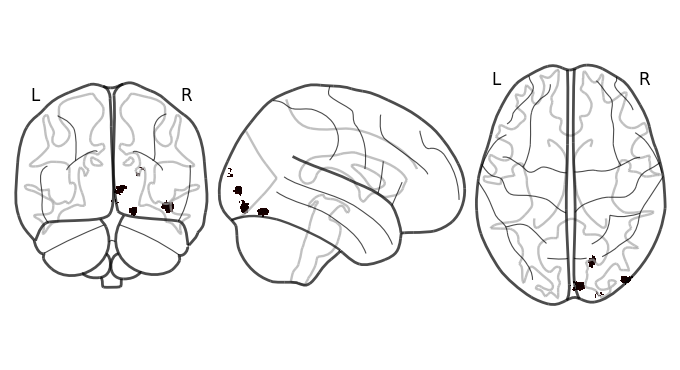

In [21]:
# --------------
from nilearn import image
from nilearn.plotting import plot_stat_map, plot_img, show
from nilearn import plotting
%matplotlib inline
#Create an image of the searchlight scores
searchlight_img = new_img_like(anat_filename, searchlight.scores_)
#Plot the searchlight scores on an anatomical background
plot_img(searchlight_img, bg_img=anat_filename,#bg_img=mean_fmri,
         title="Searchlight", display_mode="z",cut_coords=[-25,-20,-15,-10,-5,0,5],
         vmin=.40, cmap='jet', threshold=cut, black_bg=True)
#plotting.plot_glass_brain effects
fig=plotting.plot_glass_brain(searchlight_img,threshold=cut)
fig_file=outdir+'/iowa2024_sub-'+subj+'_decks_vs_outcome_searchlightNB_glass_500.png'
fig.savefig(fig_file, dpi=300)

now = datetime.now()
print('Saving glass brain with 500 most predictive voxels:',now.strftime("%H:%M:%S"))

In [23]:
from atlasreader import create_output
from IPython.display import display, HTML
import os
outdir='/work/student_folders/Ida_D_folder/notebooks_fMRI/Portfolio_2/Decoding'
if not os.path.exists(outdir):
    os.mkdir(outdir)

# Save the searchlight image into a NIfTI file
file_name = outdir+'/iowa2024_searchlight_par'+subj+'.nii.gz'
#Create table with atlas coordinates
create_output(searchlight_img, voxel_thresh=cut, cluster_extent=2,direction='pos',outdir=outdir)
#Atlasreader automatically saves results to both .png-files and a csv-file. Look in your working directory.
pd.read_csv('/work/student_folders/Ida_D_folder/notebooks_fMRI/Portfolio_2/Decoding/atlasreader_peaks.csv')

#Display coordinates
wd=os.getcwd()
os.chdir(outdir)
peaks=pd.read_csv('/work/student_folders/Ida_D_folder/notebooks_fMRI/Portfolio_2/Decoding/atlasreader_peaks.csv')
display(peaks)
clusters=pd.read_csv('/work/student_folders/Ida_D_folder/notebooks_fMRI/Portfolio_2/Decoding/atlasreader_clusters.csv')
display(clusters)
os.chdir(wd)

,cluster_id,peak_x,peak_y,peak_z,peak_value,volume_mm,aal,desikan_killiany,harvard_oxford
0,1.0,45.0,-89.012,-9.610,0.933692,188.996740,no_label,Unknown,9.0% Right_Lateral_Occipital_Cortex_inferior_d...
1,2.0,17.0,-78.265,-13.518,0.937538,137.452174,Lingual_R,ctx-rh-lingual,49.0% Right_Occipital_Fusiform_Gyrus; 23.0% Ri...
2,3.0,8.0,-93.897,4.068,0.933538,125.043297,Calcarine_R,ctx-rh-pericalcarine,68.0% Right_Occipital_Pole; 5.0% Right_Lingual...
3,4.0,19.0,-99.759,12.861,0.914000,4.772645,Cuneus_R,ctx-rh-lateraloccipital,64.0% Right_Occipital_Pole
4,5.0,20.0,-98.782,12.861,0.906154,4.772645,Cuneus_R,ctx-rh-lateraloccipital,69.0% Right_Occipital_Pole
5,6.0,23.0,-99.759,17.746,0.000000,2.863587,Occipital_Sup_R,Unknown,38.0% Right_Occipital_Pole
6,7.0,3.0,-90.966,-6.679,0.000000,2.863587,Calcarine_L,ctx-lh-lingual,19.0% Right_Lingual_Gyrus; 16.0% Right_Occipit...
7,8.0,23.0,-100.736,18.723,0.906154,1.909058,Occipital_Sup_R,Unknown,27.0% Right_Occipital_Pole
8,9.0,6.0,-91.943,-1.794,0.906154,1.909058,Calcarine_L,ctx-rh-lingual,52.0% Right_Occipital_Pole; 14.0% Right_Lingua...
9,10.0,3.0,-95.851,0.160,0.902154,1.909058,Calcarine_L,Unknown,28.0% Right_Occipital_Pole; 21.0% Left_Occipit...


,cluster_id,peak_x,peak_y,peak_z,cluster_mean,volume_mm,aal,desikan_killiany,harvard_oxford
0,1.0,45.0,-89.012,-9.610,0.912933,188.996740,64.65% Occipital_Inf_R; 35.35% no_label,56.57% Unknown; 35.86% ctx-rh-lateraloccipital...,95.45% Right_Lateral_Occipital_Cortex_inferior...
1,2.0,17.0,-78.265,-13.518,0.911956,137.452174,62.50% Lingual_R; 37.50% Cerebelum_6_R,52.08% ctx-rh-lingual; 43.06% Unknown,90.97% Right_Occipital_Fusiform_Gyrus; 9.03% R...
2,3.0,8.0,-93.897,4.068,0.911564,125.043297,63.36% Calcarine_R; 35.88% Calcarine_L,66.41% ctx-rh-pericalcarine; 14.50% Unknown; 1...,100.00% Right_Occipital_Pole
3,4.0,19.0,-99.759,12.861,0.906246,4.772645,60.00% Cuneus_R; 40.00% no_label,80.00% ctx-rh-lateraloccipital; 20.00% Unknown,100.00% Right_Occipital_Pole
4,5.0,20.0,-98.782,12.861,0.904431,4.772645,60.00% Cuneus_R; 40.00% Occipital_Sup_R,80.00% ctx-rh-lateraloccipital; 20.00% Unknown,100.00% Right_Occipital_Pole
5,6.0,23.0,-99.759,17.746,0.905692,2.863587,66.67% Occipital_Sup_R; 33.33% no_label,66.67% Unknown; 33.33% ctx-rh-lateraloccipital,100.00% Right_Occipital_Pole
6,7.0,3.0,-90.966,-6.679,0.902308,2.863587,100.00% Calcarine_L,100.00% ctx-lh-lingual,100.00% Right_Lingual_Gyrus
7,8.0,23.0,-100.736,18.723,0.904231,1.909058,100.00% Occipital_Sup_R,100.00% Unknown,100.00% Right_Occipital_Pole
8,9.0,6.0,-91.943,-1.794,0.904308,1.909058,100.00% Calcarine_L,100.00% ctx-rh-lingual,100.00% Right_Occipital_Pole
9,10.0,3.0,-95.851,0.160,0.902077,1.909058,100.00% Calcarine_L,100.00% Unknown,50.00% Right_Occipital_Pole; 50.00% Left_Occip...


### Make a permutation classification test on the 2nd data split using the best voxels

In [24]:
now = datetime.now()
print('Perform permutation test on test set using 500 predictive voxels:',now.strftime("%H:%M:%S"))
from sklearn.naive_bayes import GaussianNB
from nilearn.input_data import NiftiMasker
masker = NiftiMasker(mask_img=process_mask2_img, standardize=False)

# We use masker to retrieve a 2D array ready
# for machine learning with scikit-learn
fmri_masked = masker.fit_transform(fmri_img_test)
#Print size of matrix (images x voxels)
print(fmri_masked.shape)

from sklearn.model_selection import permutation_test_score
score_cv_test, scores_perm, pvalue= permutation_test_score(
    GaussianNB(), fmri_masked, conditions_test, cv=10, n_permutations=1000, 
    n_jobs=-1, random_state=0, verbose=0, scoring=None)
print("Classification Accuracy: %s (pvalue : %s)" % (score_cv_test, pvalue))



Perform permutation test on test set using 500 predictive voxels: 09:11:14


/work/notebooks_fMRI/virt_env/lib/python3.10/site-packages/nilearn/maskers/nifti_masker.py:110: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


(64, 497)
Classification Accuracy: 0.9166666666666667 (pvalue : 0.000999000999000999)


## Saving permutation outcomes

In [25]:
import pickle

now = datetime.now()
print('Saving permutation scores:',now.strftime("%H:%M:%S"))
#Save the permutation scores

# Saving the objects:
f = open(outdir+'/iowa2024_subj_'+subj+'_searchlight_perms.pkl', 'wb')
pickle.dump([score_cv_test, scores_perm, pvalue], f)
f.close()

# Getting back the objects:
#f = open('/work/MikkelWallentin#6287/InSpe_first_level_models_all_trials_searchlight_perms.pkl', 'rb')
#score_cv_test, scores_perm, pvalue = pickle.load(f)
#f.close()


Saving permutation scores: 09:11:59


### View a histogram of permutation scores

Plotting and saving permutation scores: 09:12:21


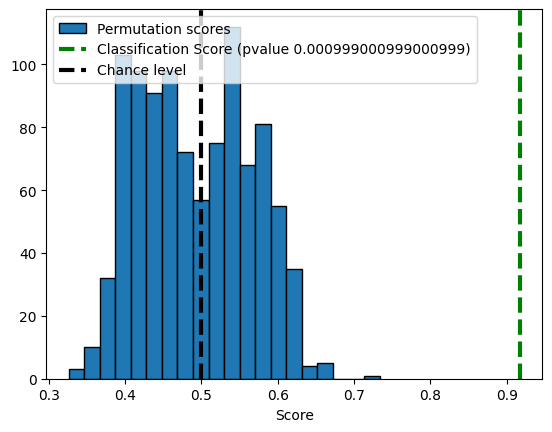

In [26]:
now = datetime.now()
print('Plotting and saving permutation scores:',now.strftime("%H:%M:%S"))

import numpy as np
import matplotlib.pyplot as plt
#How many classes
n_classes = np.unique(conditions_test).size

plt.hist(scores_perm, 20, label='Permutation scores',
         edgecolor='black')
ylim = plt.ylim()
plt.plot(2 * [score_cv_test], ylim, '--g', linewidth=3,
         label='Classification Score'
         ' (pvalue %s)' % pvalue)
plt.plot(2 * [1. / n_classes], ylim, '--k', linewidth=3, label='Chance level')

plt.ylim(ylim)
plt.legend()
plt.xlabel('Score')

plt.savefig(outdir+'/iowa2024_'+subj+'_decs_vs_outcome_sub_perm.png', dpi=300)
plt.show()